In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Configure visualization style
sns.set(style="whitegrid")
%matplotlib inline

In [11]:
# Load the datasets
df_feedback = pd.read_csv('Customer_Feedback_Data.csv')
df_transaction = pd.read_csv('Transaction_Data.csv')
df_product = pd.read_csv('Product_Offering_Data.csv')

# Display initial info to verify loading
print("Feedback Data Shape:", df_feedback.shape)
print("Transaction Data Shape:", df_transaction.shape)
print("Product Data Shape:", df_product.shape)

Feedback Data Shape: (5050, 4)
Transaction Data Shape: (5050, 5)
Product Data Shape: (15, 6)


In [12]:
# 1. Impute Missing Values with Median
# Calculate medians
satisfaction_median = df_feedback['Satisfaction_Score'].median()
transaction_median = df_transaction['Transaction_Amount'].median()

# Fill missing values
df_feedback['Satisfaction_Score'] = df_feedback['Satisfaction_Score'].fillna(satisfaction_median)
df_transaction['Transaction_Amount'] = df_transaction['Transaction_Amount'].fillna(transaction_median)

# Note: Target_Age_Group in Product data is entirely missing, so we leave it as NaN or drop it if needed.

# 2. Sort Data for Sequential Merging
# Ensure transactions are chronological and feedback is ordered by Customer ID
df_transaction = df_transaction.sort_values(by=['Customer_ID', 'Transaction_Date'])
df_feedback = df_feedback.sort_values(by=['Customer_ID'])

# Create a sequence ID to align the Nth transaction with the Nth feedback per customer
df_transaction['seq_id'] = df_transaction.groupby('Customer_ID').cumcount()
df_feedback['seq_id'] = df_feedback.groupby('Customer_ID').cumcount()

In [13]:
# 1. Merge Transaction and Feedback
# Outer join ensures we keep all records even if counts don't match perfectly
df_merged = pd.merge(df_transaction, df_feedback, on=['Customer_ID', 'seq_id'], how='outer')

# 2. Map Transaction Types to Product Types
type_mapping = {
    'Purchase': 'Credit Card',
    'Bill Payment': 'Savings Account',
    'Investment': 'Investment',
    'Loan Payment': 'Loan'
}
df_merged['Product_Type_Map'] = df_merged['Transaction_Type'].map(type_mapping)

# 3. Merge Product Data
# Deduplicate product data by type to avoid duplicating rows (keeping the first occurrence)
df_product_unique = df_product.drop_duplicates(subset=['Product_Type'], keep='first')

# Final Merge
df_final = pd.merge(df_merged, df_product_unique, left_on='Product_Type_Map', right_on='Product_Type', how='left')

# Drop helper columns
df_final = df_final.drop(columns=['seq_id', 'Product_Type_Map'])

# Display result
print("Final Merged Data Shape:", df_final.shape)
df_final.head()

Final Merged Data Shape: (6237, 14)


,Transaction_ID,Customer_ID,Transaction_Date,Transaction_Amount,Transaction_Type,Satisfaction_Score,Feedback_Comments,Likelihood_to_Recommend,Product_ID,Product_Name,Product_Type,Risk_Level,Target_Age_Group,Target_Income_Group
0,29.0,1,2023-01-02 04:00:00,156.0,Loan Payment,10.0,Very satisfied,9.0,4.0,Mortgage Loan,Loan,Medium,NaN,High
1,282.0,1,2023-01-12 17:00:00,1572.0,Bill Payment,7.0,Good service,9.0,2.0,Gold Savings Account,Savings Account,Low,NaN,Low
2,2883.0,1,2023-05-01 02:00:00,4867.0,Bill Payment,NaN,NaN,NaN,2.0,Gold Savings Account,Savings Account,Low,NaN,Low
3,3135.0,1,2023-05-11 14:00:00,1278.0,Investment,NaN,NaN,NaN,3.0,High-Yield Investment Account,Investment,High,NaN,High
4,3626.0,1,2023-06-01 01:00:00,3970.0,Purchase,NaN,NaN,NaN,1.0,Platinum Credit Card,Credit Card,Medium,NaN,Medium


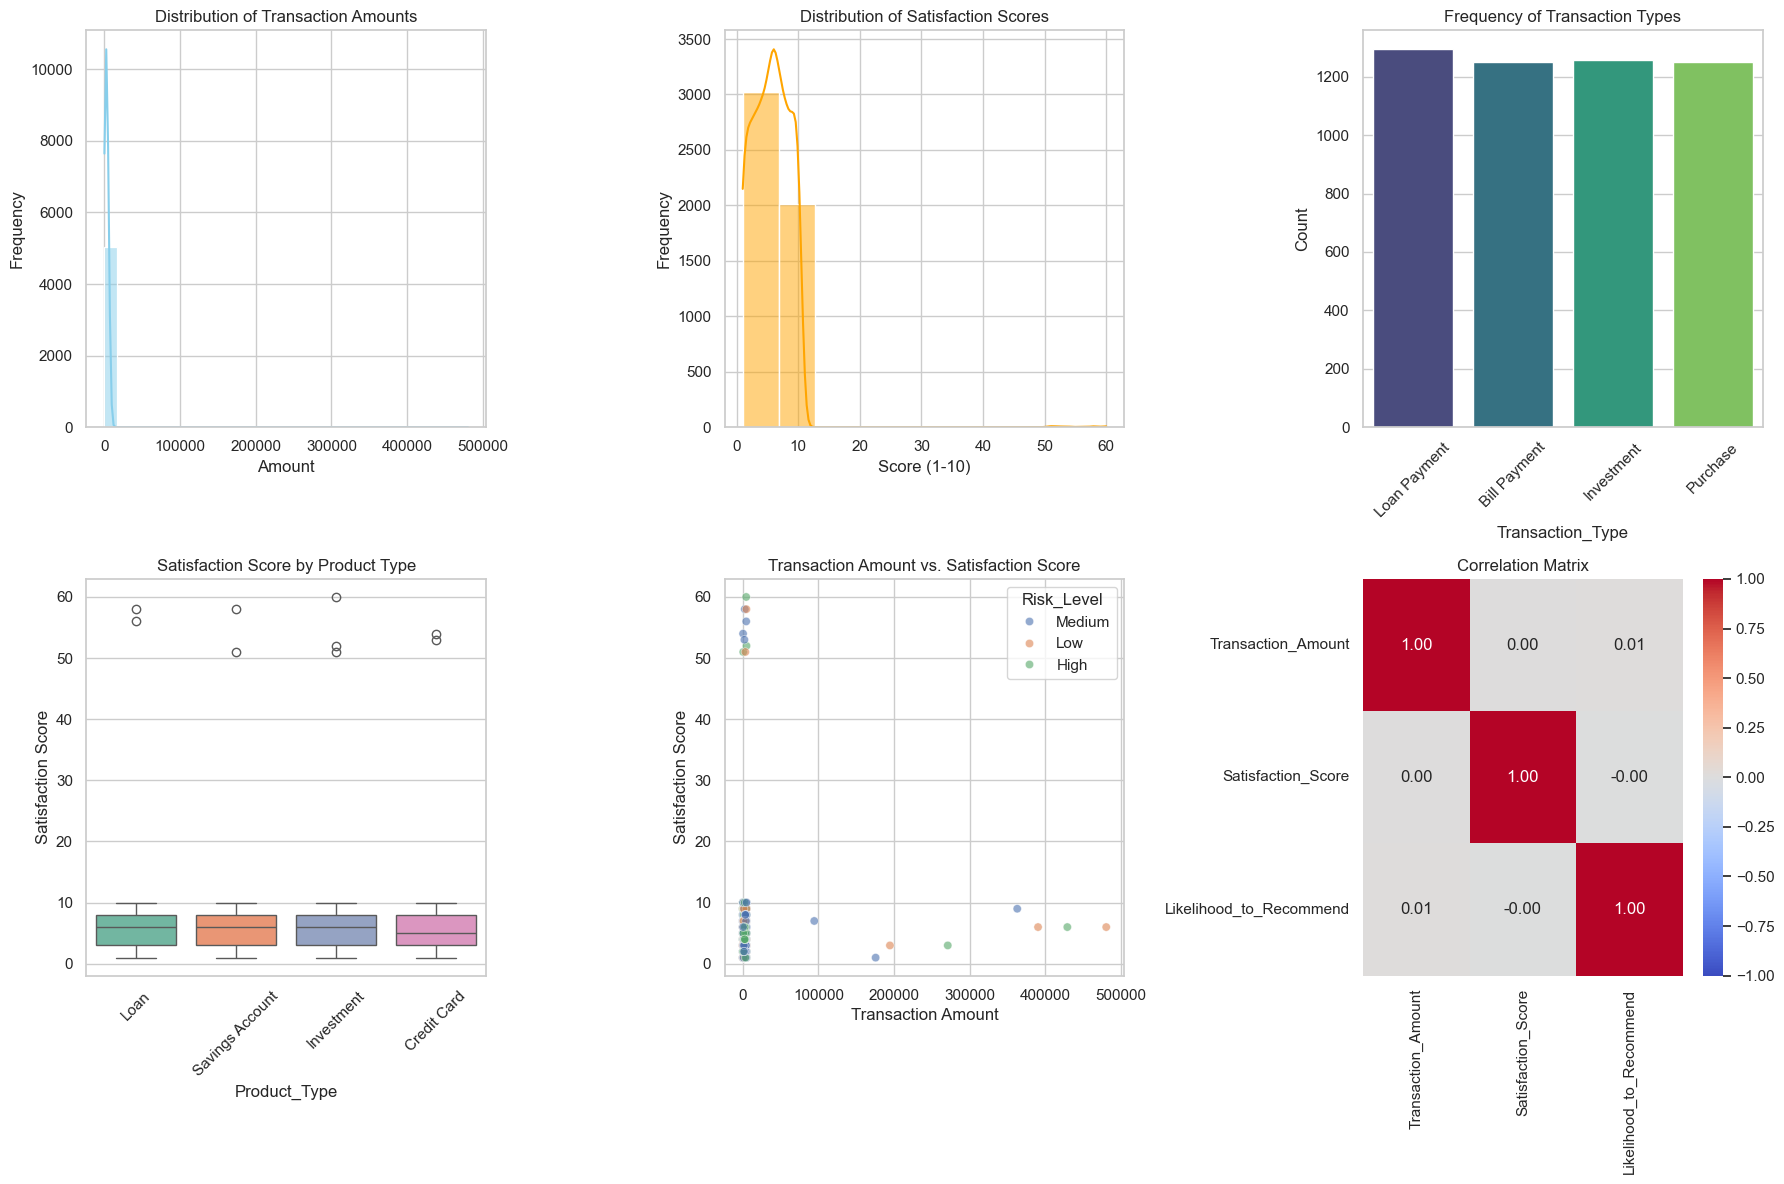

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure size for multiple subplots
plt.figure(figsize=(18, 12))

# 1. Histogram of Transaction Amount
plt.subplot(2, 3, 1)
sns.histplot(df_final['Transaction_Amount'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Frequency')

# 2. Histogram of Satisfaction Score
plt.subplot(2, 3, 2)
sns.histplot(df_final['Satisfaction_Score'], kde=True, bins=10, color='orange')
plt.title('Distribution of Satisfaction Scores')
plt.xlabel('Score (1-10)')
plt.ylabel('Frequency')

# 3. Bar Chart of Transaction Types (FIXED)
plt.subplot(2, 3, 3)
sns.countplot(x='Transaction_Type', data=df_final, hue='Transaction_Type', legend=False, palette='viridis')
plt.title('Frequency of Transaction Types')
plt.xticks(rotation=45)
plt.ylabel('Count')

# 4. Box Plot: Satisfaction by Product Type (FIXED)
plt.subplot(2, 3, 4)
sns.boxplot(x='Product_Type', y='Satisfaction_Score', data=df_final, hue='Product_Type', legend=False, palette='Set2')
plt.title('Satisfaction Score by Product Type')
plt.xticks(rotation=45)
plt.ylabel('Satisfaction Score')

# 5. Scatter Plot: Amount vs Satisfaction (colored by Risk Level)
plt.subplot(2, 3, 5)
sns.scatterplot(x='Transaction_Amount', y='Satisfaction_Score', hue='Risk_Level', data=df_final, alpha=0.6, palette='deep')
plt.title('Transaction Amount vs. Satisfaction Score')
plt.xlabel('Transaction Amount')
plt.ylabel('Satisfaction Score')

# 6. Correlation Heatmap
plt.subplot(2, 3, 6)
numeric_cols = ['Transaction_Amount', 'Satisfaction_Score', 'Likelihood_to_Recommend']
corr = df_final[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title('Correlation Matrix')

plt.tight_layout()
plt.show()

PCA Loadings (Drivers):
                              PC1       PC2
Transaction_Amount       0.569156 -0.596347
Satisfaction_Score       0.450205  0.802107
Likelihood_to_Recommend  0.688024 -0.031538


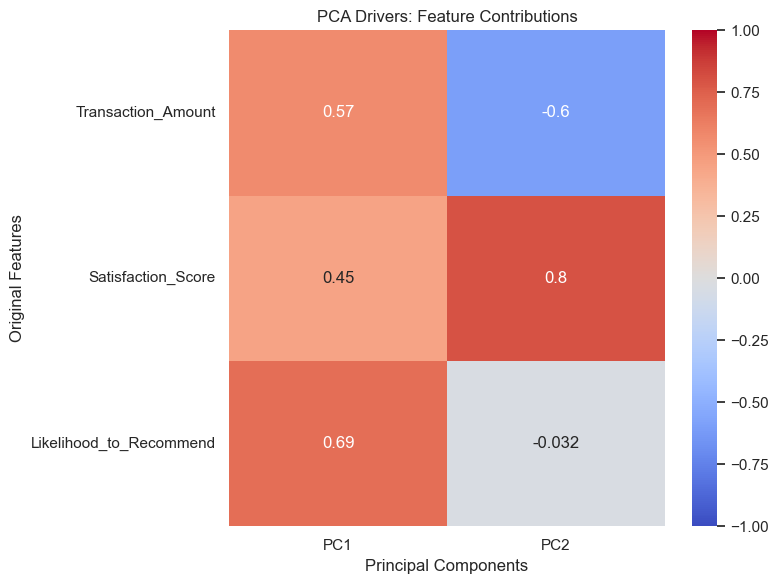

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1. Ensure Data is Ready (Re-running minimal prep if needed)
# Load Data
df_feedback = pd.read_csv('Customer_Feedback_Data.csv')
df_transaction = pd.read_csv('Transaction_Data.csv')
df_product = pd.read_csv('Product_Offering_Data.csv')

# Preprocessing
df_feedback['Satisfaction_Score'] = df_feedback['Satisfaction_Score'].fillna(df_feedback['Satisfaction_Score'].median())
df_transaction['Transaction_Amount'] = df_transaction['Transaction_Amount'].fillna(df_transaction['Transaction_Amount'].median())
df_product_clean = df_product.drop_duplicates()

# Sort & Sequential Merge
df_transaction = df_transaction.sort_values(by=['Customer_ID', 'Transaction_Date'])
df_feedback = df_feedback.sort_values(by=['Customer_ID'])
df_transaction['seq_id'] = df_transaction.groupby('Customer_ID').cumcount()
df_feedback['seq_id'] = df_feedback.groupby('Customer_ID').cumcount()

df_merged = pd.merge(df_transaction, df_feedback, on=['Customer_ID', 'seq_id'], how='outer')

# Product Mapping
type_mapping = {
    'Purchase': 'Credit Card',
    'Bill Payment': 'Savings Account',
    'Investment': 'Investment',
    'Loan Payment': 'Loan'
}
df_merged['Product_Type_Mapped'] = df_merged['Transaction_Type'].map(type_mapping)
df_product_unique_type = df_product_clean.drop_duplicates(subset=['Product_Type'], keep='first')
df_final = pd.merge(df_merged, df_product_unique_type, left_on='Product_Type_Mapped', right_on='Product_Type', how='left')

# 2. PCA Fitting (The crucial missing step)
features = ['Transaction_Amount', 'Satisfaction_Score', 'Likelihood_to_Recommend']

# Drop rows with missing values in the feature columns
df_pca = df_final.dropna(subset=features).copy()

# Standardize
x = df_pca[features].values
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Fit PCA
pca = PCA(n_components=2)
pca.fit(x_scaled)

# 3. Create Drivers DataFrame (Loadings)
loadings_df = pd.DataFrame(
    pca.components_.T, 
    columns=['PC1', 'PC2'], 
    index=features
)

print("PCA Loadings (Drivers):")
print(loadings_df)

# 4. Plot Heatmap of Drivers
plt.figure(figsize=(8, 6))
sns.heatmap(loadings_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('PCA Drivers: Feature Contributions')
plt.ylabel('Original Features')
plt.xlabel('Principal Components')
plt.tight_layout()
plt.show()

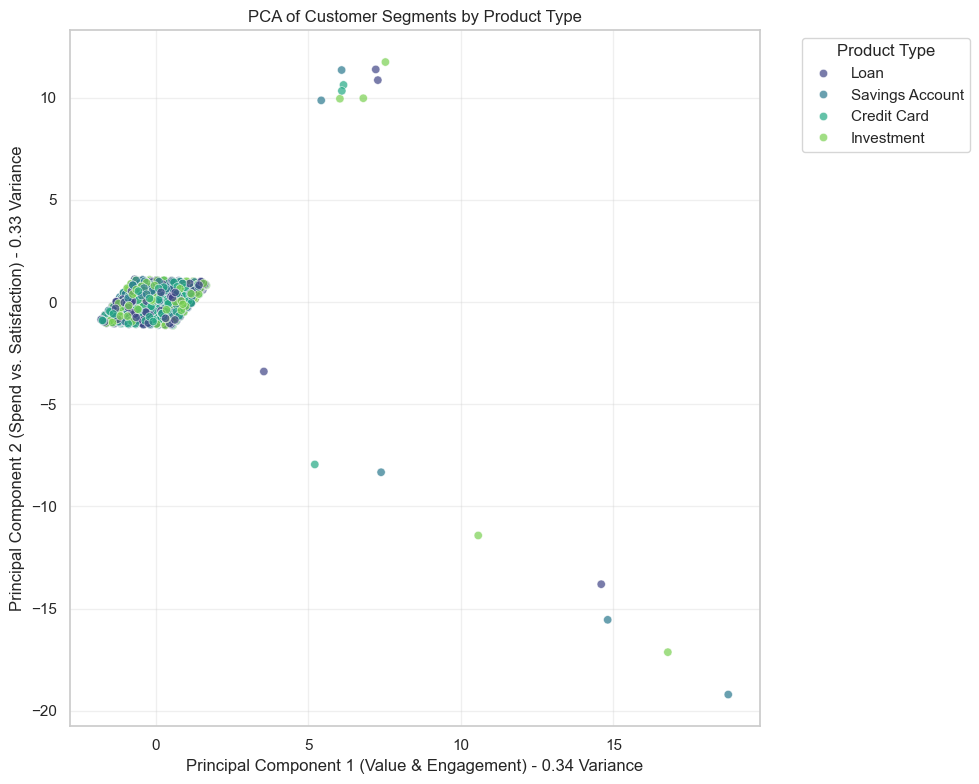

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1. Load Data
df_feedback = pd.read_csv('Customer_Feedback_Data.csv')
df_transaction = pd.read_csv('Transaction_Data.csv')
df_product = pd.read_csv('Product_Offering_Data.csv')

# 2. Preprocessing
# Fill missing values
df_feedback['Satisfaction_Score'] = df_feedback['Satisfaction_Score'].fillna(df_feedback['Satisfaction_Score'].median())
df_transaction['Transaction_Amount'] = df_transaction['Transaction_Amount'].fillna(df_transaction['Transaction_Amount'].median())

# Deduplicate product data
df_product_clean = df_product.drop_duplicates()

# Sort for sequential merge
df_transaction = df_transaction.sort_values(by=['Customer_ID', 'Transaction_Date'])
df_feedback = df_feedback.sort_values(by=['Customer_ID'])

# Create sequence ID
df_transaction['seq_id'] = df_transaction.groupby('Customer_ID').cumcount()
df_feedback['seq_id'] = df_feedback.groupby('Customer_ID').cumcount()

# Merge Transaction and Feedback
df_merged = pd.merge(df_transaction, df_feedback, on=['Customer_ID', 'seq_id'], how='outer')

# Map Transaction Type to Product Type
type_mapping = {
    'Purchase': 'Credit Card',
    'Bill Payment': 'Savings Account',
    'Investment': 'Investment',
    'Loan Payment': 'Loan'
}
df_merged['Product_Type_Mapped'] = df_merged['Transaction_Type'].map(type_mapping)

# Prepare Product Data for Merge
df_product_unique_type = df_product_clean.drop_duplicates(subset=['Product_Type'], keep='first')
df_final = pd.merge(df_merged, df_product_unique_type, left_on='Product_Type_Mapped', right_on='Product_Type', how='left')

# 3. PCA Calculation
features = ['Transaction_Amount', 'Satisfaction_Score', 'Likelihood_to_Recommend']
# Drop rows with missing values in these specific columns for PCA
df_pca = df_final.dropna(subset=features).copy()
df_pca.reset_index(drop=True, inplace=True)

# Standardize features
x = df_pca[features].values
x = StandardScaler().fit_transform(x)

# Fit PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)

# Create DataFrame for plotting
pca_df = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
final_pca_df = pd.concat([pca_df, df_pca[['Product_Type', 'Risk_Level']]], axis=1)

# 4. Generate Scatter Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PC1', 
    y='PC2', 
    hue='Product_Type', 
    data=final_pca_df, 
    palette='viridis', 
    alpha=0.7
)

# Add informative labels
plt.title('PCA of Customer Segments by Product Type')
plt.xlabel(f'Principal Component 1 (Value & Engagement) - {pca.explained_variance_ratio_[0]:.2f} Variance')
plt.ylabel(f'Principal Component 2 (Spend vs. Satisfaction) - {pca.explained_variance_ratio_[1]:.2f} Variance')
plt.legend(title='Product Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()